## Full GRAPPA reconstruction demo 
###### Author: Zimu Huo
###### Date: 02.2022

In GRAPPA, the missing target samples are synthesized by a linear combination of acquired neighboring k-space data. Specifically, the weight of the linear combination forms a GRAPPA kernel that is trained using the fully sampled region in k-space, extending through the phase encoding, frequency encoding, and coil dimensions. For Cartesian acquisition, the GRAPPA kernel is shift invariant, and once trained, it can be applied throughout k-space. The reconstruction of the missing data in k-space can be expressed in vector form as:
$$
S_{targ} = W * S_{acq} 
$$
where \( * \) denotes the convolution operator in k-space. This means the kernel moves from point to point in k-space, and the weights are multiplied by the kernel source points to reconstruct the kernel's target points. However, this can also be implemented in image space as a series of multiplications, which is visualised in visualise_grappa.ipynb. 

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Mark A. Griswold et al. 
    Title: Generalized Autocalibrating Partially Parallel Acquisitions (GRAPPA)
    Link: https://pubmed.ncbi.nlm.nih.gov/12111967/
    

In [2]:
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
from util.coil import *
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
import util.phantom as phantom
from util.gfactor import *
from tqdm.notebook import tqdm
from util.zpad import *
from scipy import io
from util.grappa import *
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
data = phantom.brain(256, 4)

In [4]:
rawImage = ifft2c(data)
acs = simulate.acs(data, (32, 32))

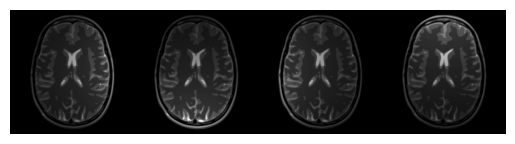

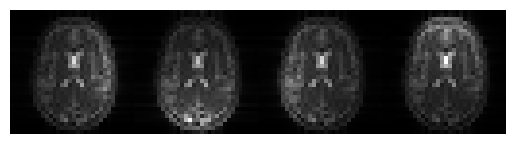

In [5]:
# fully sampled data
show(rawImage)
# low resolution fully sampled center of k-space
show(ifft2c(acs))

<div style="font-size: 1.2em;">
In a conventional MRI acquisition, multiple RF receivers are utilized to capture the image data, with each receiver positioned at a distinct spatial location relative to the image. Consequently, certain regions of the image will exhibit greater sensitivity to particular receivers, implying that each coil provides a somewhat distinct perspective of the imaging subject. By treating this unique perspective, or spatial sensitivity modulation, as an additional layer of spatial encoding - similar to the phase encoding and frequency encoding steps - a greater amount of information can be extracted and utilized in reconstructing the undersampled image. This is the foundation of the GRAPPA. 
</div>

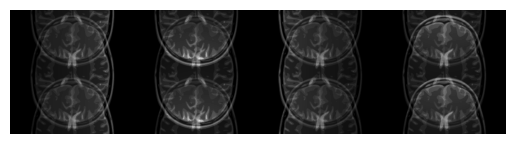

In [6]:
dataR = np.zeros(data.shape, dtype = complex)
R = 2
dataR[::R] = data[::R]
show(ifft2c(dataR))

<div style="font-size: 1.2em;">
In this particular instance, the data was undersampled by skipping every other line in the phase encoding direction. This violates the Nyquist sampling rate and results in the image being duplicated and overlapped on top of the original image, leading to an artifact known as aliasing. To correct for this artifact, a separate low-resolution dataset is acquired that corresponds to the center of the K space. This dataset is used as a reference signal to correct the aliasing artifact during image reconstruction. 
    
</div>

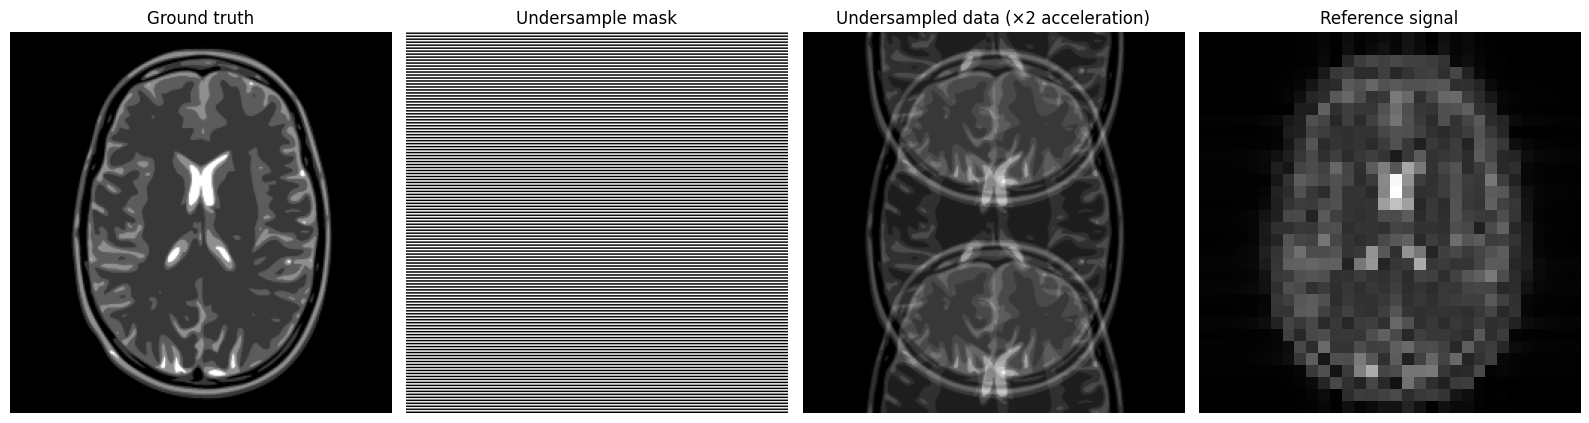

In [7]:
plt.figure(figsize=(16, 12))
plt.subplot(142)
plt.imshow(show_mask(dataR),cmap='gray')
plt.title("Undersample mask")
plt.axis('off')
plt.subplot(141)
plt.axis('off')
plt.imshow(np.abs(rsos(ifft2c(data))),cmap='gray')
plt.title("Ground truth")
plt.subplot(143)
plt.axis('off')
plt.imshow(np.abs(rsos(ifft2c(dataR))),cmap='gray')
plt.title("Undersampled data (×2 acceleration)")
plt.subplot(144)
plt.imshow(np.abs(rsos(ifft2c(acs))),cmap='gray')
plt.title("Reference signal")
plt.axis('off')
plt.tight_layout()
plt.savefig("grappa_input.png", format = "pdf",bbox_inches='tight')

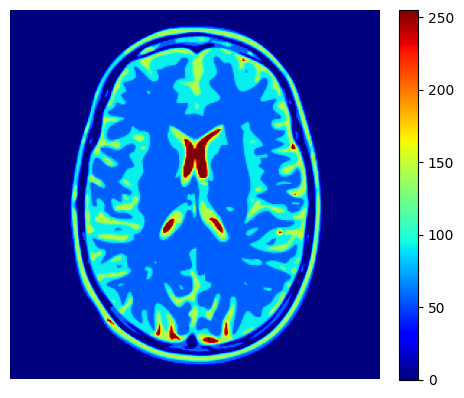

In [8]:
mask  = rsos(ifft2c(data))
mask[mask < 0.1] = 0
showc(mask)

In [9]:
#To simplify, let's assume that the coil is known, which can theoretically be obtained from ACS data. The simplest approach is to divide each coil image by the RSOS-combined one. However, this method is quite sensitive to low SNR.
#Additional challenges arise when zero-padding low-resolution data to higher resolution. More advanced algorithms, such as ESPIRiT, have been proposed to address these issues.
mask  = rsos(ifft2c(data))
mask[mask < 0.1] = 0
mask[mask>0.1] = 1
coilmaps = walsh_cmap(ifft2c(data)) 

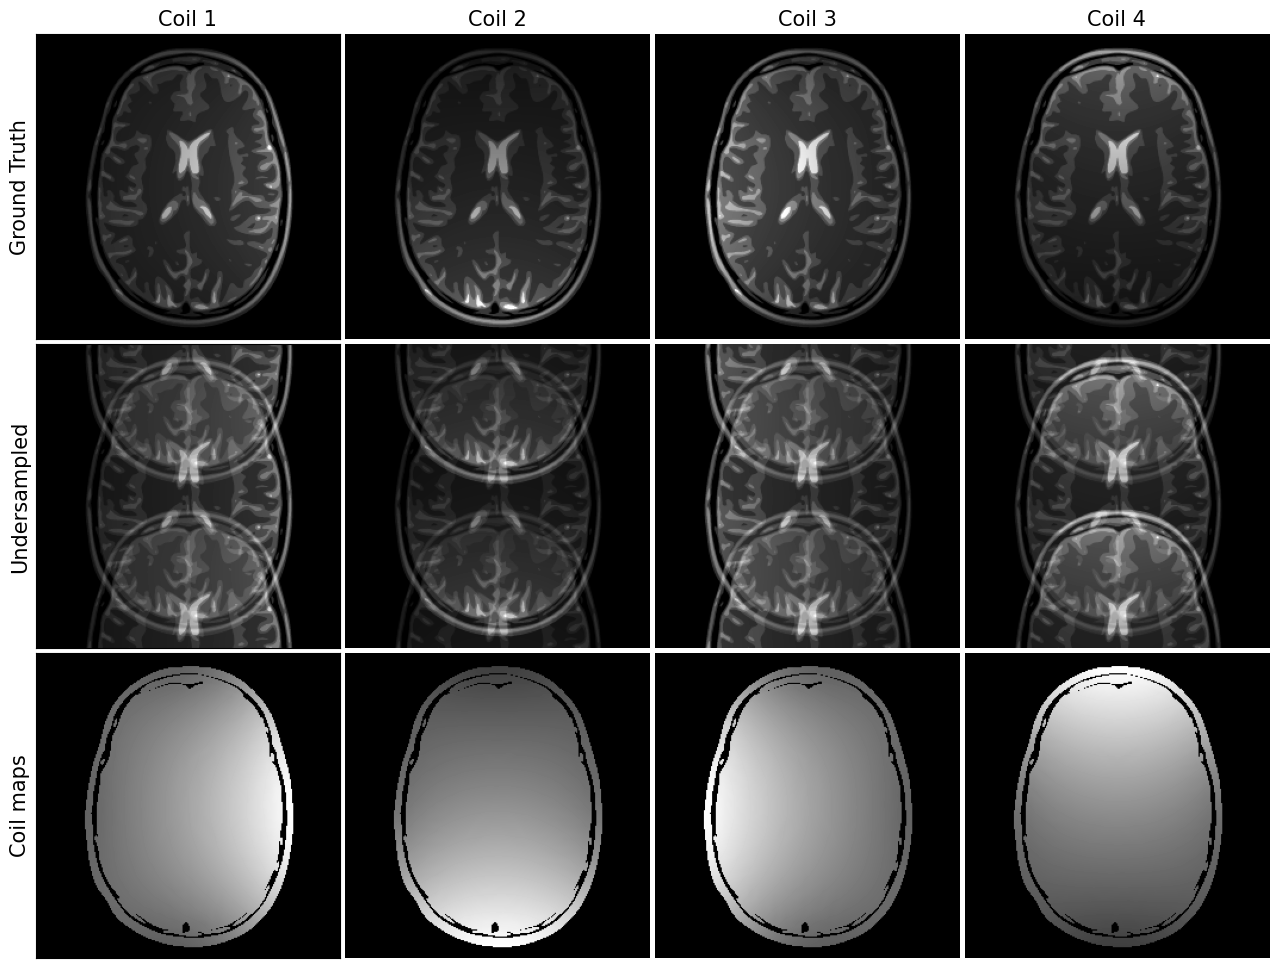

In [10]:
fig = plt.figure(figsize = (16,12))
grid = ImageGrid(fig, 111,
                 nrows_ncols = (3,4),
                 axes_pad = 0.05,
                )
grid[0].imshow(abs(ifft2c(data[...,0])), cmap = "gray")
grid[0].set_title('Coil 1', fontsize = 15)
grid[0].set_ylabel("Ground Truth", fontsize = 15)
grid[0].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

grid[1].imshow(abs(ifft2c(data[...,1])), cmap = "gray")
grid[1].axis('off')
grid[1].set_title('Coil 2', fontsize = 15)

grid[2].imshow(abs(ifft2c(data[...,2])), cmap = "gray")
grid[2].axis('off')
grid[2].set_title('Coil 3', fontsize = 15)

grid[3].imshow(abs(ifft2c(data[...,3])), cmap = "gray")
grid[3].axis('off')
grid[3].set_title('Coil 4', fontsize = 15)


grid[4].imshow(abs(ifft2c(dataR[...,0])), cmap = "gray")
grid[4].set_ylabel("Undersampled", fontsize = 15)
grid[4].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

grid[5].imshow(abs(ifft2c(dataR[...,1])), cmap = "gray")
grid[5].axis('off')
grid[6].imshow(abs(ifft2c(dataR[...,2])), cmap = "gray")
grid[6].axis('off')
grid[7].imshow(abs(ifft2c(dataR[...,3])), cmap = "gray")
grid[7].axis('off')

grid[8].imshow(abs((coilmaps[...,0]))*mask, cmap = "gray")
grid[8].set_ylabel("Coil maps", fontsize = 15)
grid[8].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

grid[9].imshow(abs((coilmaps[...,1]))*mask, cmap = "gray")
grid[9].axis('off')
grid[10].imshow(abs((coilmaps[...,2]))*mask, cmap = "gray")
grid[10].axis('off')
grid[11].imshow(abs((coilmaps[...,3]))*mask, cmap = "gray")
grid[11].axis('off')
plt.savefig("grappa_cmaps.png", format = "pdf",bbox_inches='tight')

In [11]:
def grappa1_weights(calib, R, kh = 4, kw = 5, lamda = 0.01):
    calib = np.moveaxis(calib, -1, 0) # move the coil to the front -> fft in the axis 3 and 4
    [nc, ncy, ncx] = calib.shape
    ks = nc*kh*kw
    nt = (ncy-(kh-1)*R)*(ncx-(kw-1))
    inMat=np.zeros([ks,nt], dtype = complex)
    outMat=np.zeros([nc*R,nt], dtype = complex)
    n = 0
    for x in (np.arange(np.floor(kw/2),ncx-np.floor(kw/2), dtype=int)):
        for y in (np.arange(ncy-(kh-1)*R)):
            inMat[...,n] = calib[:,y:y+kh*R:R, int(x-np.floor(kw/2)):int(x+np.floor(kw/2))+1].reshape(1,-1)
            outMat[...,n] = calib[:,int(y+np.floor((R*(kh-1)+1)/2) - np.floor(R/2)):int(y+np.floor((R*(kh-1)+1)/2)-np.floor(R/2)+R),x].reshape(1,-1)
            n = n + 1  
    #wt =  outMat@pinv(inMat, 1E-4)
    inMat = inMat.T
    outMat = outMat.T
    AHA = inMat.conj().T @ inMat
    S = np.sqrt(max(np.abs(np.linalg.svd(AHA,compute_uv=False))))
    wt = np.linalg.solve(
        AHA + (lamda*S)*np.eye(AHA.shape[0]), inMat.conj().T @ outMat).T
    wt = wt.reshape(nc,R,nc,kh,kw)
    return wt

def grappa1(data, acs, kh = 4, kw = 5, lamda = 0.1,combine = True, wt= None, v= 0, R=None):
    if R is None:
        mask = np.where(data[:,0,0] == 0, 0, 1).flatten()
        R = int(np.ceil(mask.shape[0]/np.sum(mask)))
    if v:
        print("undersample factor of "+str(R))
    [ny, nx, nc] = data.shape
    
    #train
    if wt is None:
        wt = grappa1_weights(acs,R,kh,kw, lamda)
    wt = np.flip(np.flip(wt.reshape(nc,R,nc,kh,kw),axis=3),axis=4)
    w = np.zeros([nc, nc, kh*R, kw], dtype = complex)
    for r in range(R):
        w[:,:,r:R*kh:R,:] = wt[:,r,:,:,:]
    del wt
    ws_k = np.zeros([nc, nc, ny, nx], dtype = complex)
    ws_k[:,:,math.ceil((ny-kh*R)/2):math.ceil((ny+kh*R)/2),math.ceil((nx-kw)/2):math.ceil((nx+kw)/2)] = w
    wim = ifft2c(ws_k, axis = (2,3))
    return wim



In [12]:
kernels = grappa1(dataR, acs)

In [13]:
nc, nc, ny, nx= kernels.shape
kernels = np.moveaxis(kernels, 0, -1)
kernels = np.moveaxis(kernels, 0, -1)

In [14]:
kernels.shape

(256, 256, 4, 4)

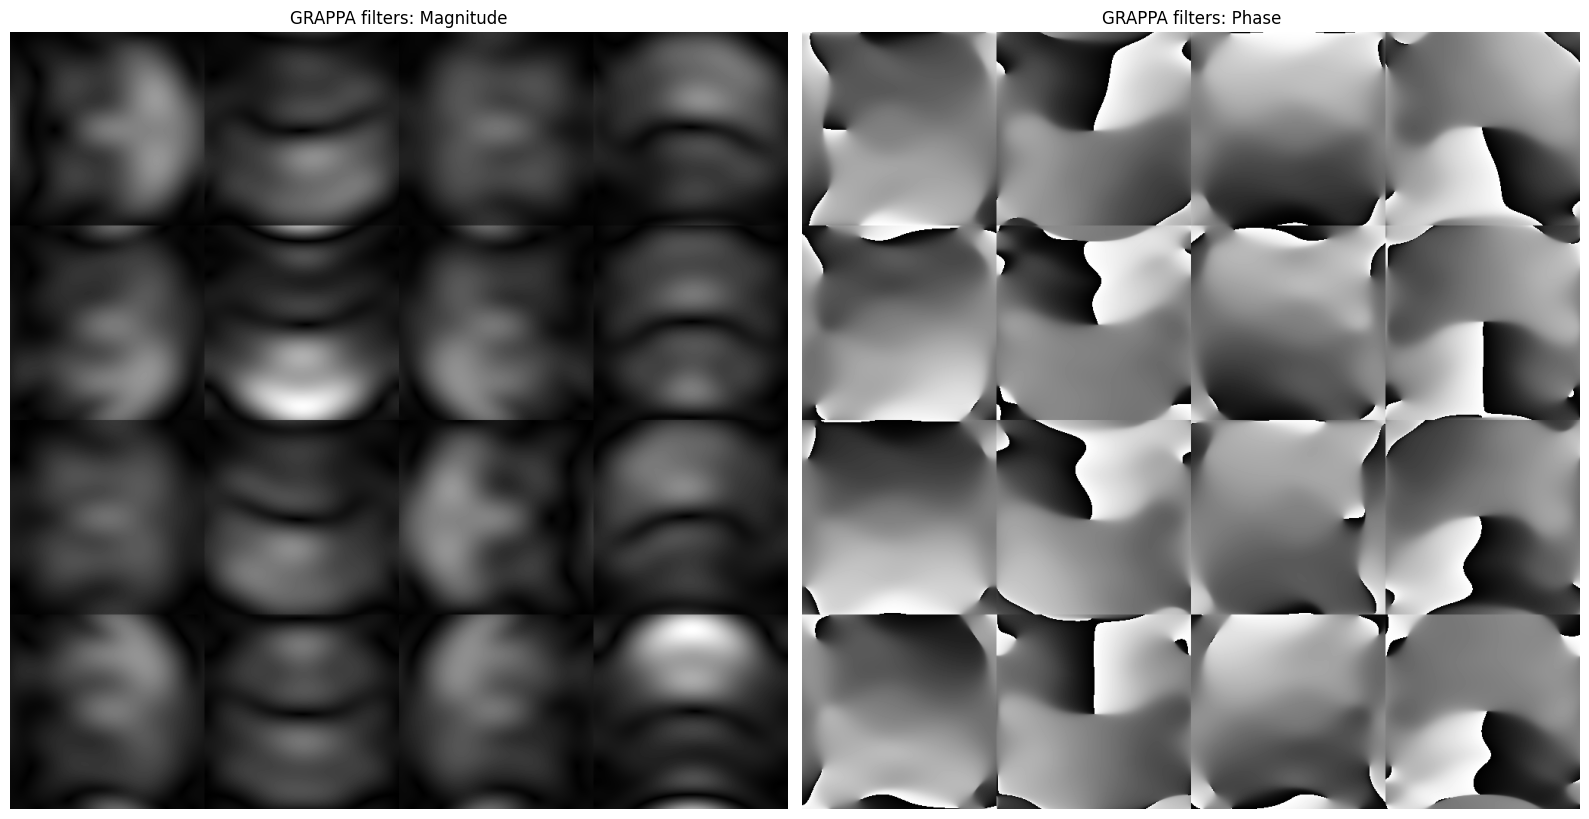

In [15]:
plt.figure(figsize = (16,12))
plt.subplot(121)
plt.title("GRAPPA filters: Magnitude")
plt.imshow(np.abs(stitch(kernels.reshape(ny,nx,-1),4)), cmap ="gray")
plt.axis('off')
plt.subplot(122)
plt.title("GRAPPA filters: Phase")
plt.imshow(np.angle(stitch(kernels.reshape(ny,nx,-1),4)), cmap ="gray")
plt.axis('off')
plt.tight_layout()

<div style="font-size: 1.2em;">
To correct for the aliasing artifact, a set of interpolation kernels is constructed or trained using the fully sampled region in k-space. These kernels, once constructed, then serve as interpolation weights to estimate the missing data points. Interesting, these kernels can also be interpreted as a set of image filters that are applied to the undersampled image to generate the final reconstructed image. For the simulated example, a total of $4 \times 4 = 16$ image filters are needed. The 4 here corresponds to the number of simulated RF receivers. 
</div>


In [16]:
def grappa1(data, acs, kh = 4, kw = 5, lamda = 0.1,combine = True, wt= None, v= 0, R=None):
    if R is None:
        mask = np.where(data[:,0,0] == 0, 0, 1).flatten()
        R = int(np.ceil(mask.shape[0]/np.sum(mask)))
    if v:
        print("undersample factor of "+str(R))
    [ny, nx, nc] = data.shape
    
    #train
    if wt is None:
        wt = grappa1_weights(acs,R,kh,kw, lamda)
    wt = np.flip(np.flip(wt.reshape(nc,R,nc,kh,kw),axis=3),axis=4)
    w = np.zeros([nc, nc, kh*R, kw], dtype = complex)
    for r in range(R):
        w[:,:,r:R*kh:R,:] = wt[:,r,:,:,:]
    del wt
    ws_k = np.zeros([nc, nc, ny, nx], dtype = complex)
    ws_k[:,:,math.ceil((ny-kh*R)/2):math.ceil((ny+kh*R)/2),math.ceil((nx-kw)/2):math.ceil((nx+kw)/2)] = w
    wim = ifft2c(ws_k, axis = (2,3))
    

    aliased_image = ifft2c(data)
    recon = np.zeros([ny,nx, nc, nc], dtype = complex) 
    for c in range (nc):
        tmp = wim[c,:,:,:]
        tmp = np.moveaxis(tmp, 0,-1)
        recon[:,:,:,c] = tmp*aliased_image
    return recon
    

In [17]:
imgkernels = grappa1(dataR, acs)

In [18]:
def grappa1(data, acs, kh = 4, kw = 5, lamda = 0.1,combine = True, wt= None, v= 0, R=None):
    if R is None:
        mask = np.where(data[:,0,0] == 0, 0, 1).flatten()
        R = int(np.ceil(mask.shape[0]/np.sum(mask)))
    if v:
        print("undersample factor of "+str(R))
    [ny, nx, nc] = data.shape
    
    #train
    if wt is None:
        wt = grappa1_weights(acs,R,kh,kw, lamda)
    wt = np.flip(np.flip(wt.reshape(nc,R,nc,kh,kw),axis=3),axis=4)
    w = np.zeros([nc, nc, kh*R, kw], dtype = complex)
    for r in range(R):
        w[:,:,r:R*kh:R,:] = wt[:,r,:,:,:]
    del wt
    ws_k = np.zeros([nc, nc, ny, nx], dtype = complex)
    ws_k[:,:,math.ceil((ny-kh*R)/2):math.ceil((ny+kh*R)/2),math.ceil((nx-kw)/2):math.ceil((nx+kw)/2)] = w
    wim = ifft2c(ws_k, axis = (2,3))
    

    aliased_image = ifft2c(data)
    recon = np.zeros([ny,nx, nc], dtype = complex) 
    for c in range (nc):
        tmp = wim[c,:,:,:]
        tmp = np.moveaxis(tmp, 0,-1)
        recon[:,:,c] = np.sum(tmp*aliased_image, axis = 2)  
    return recon  

In [19]:
result = grappa1(dataR, acs)

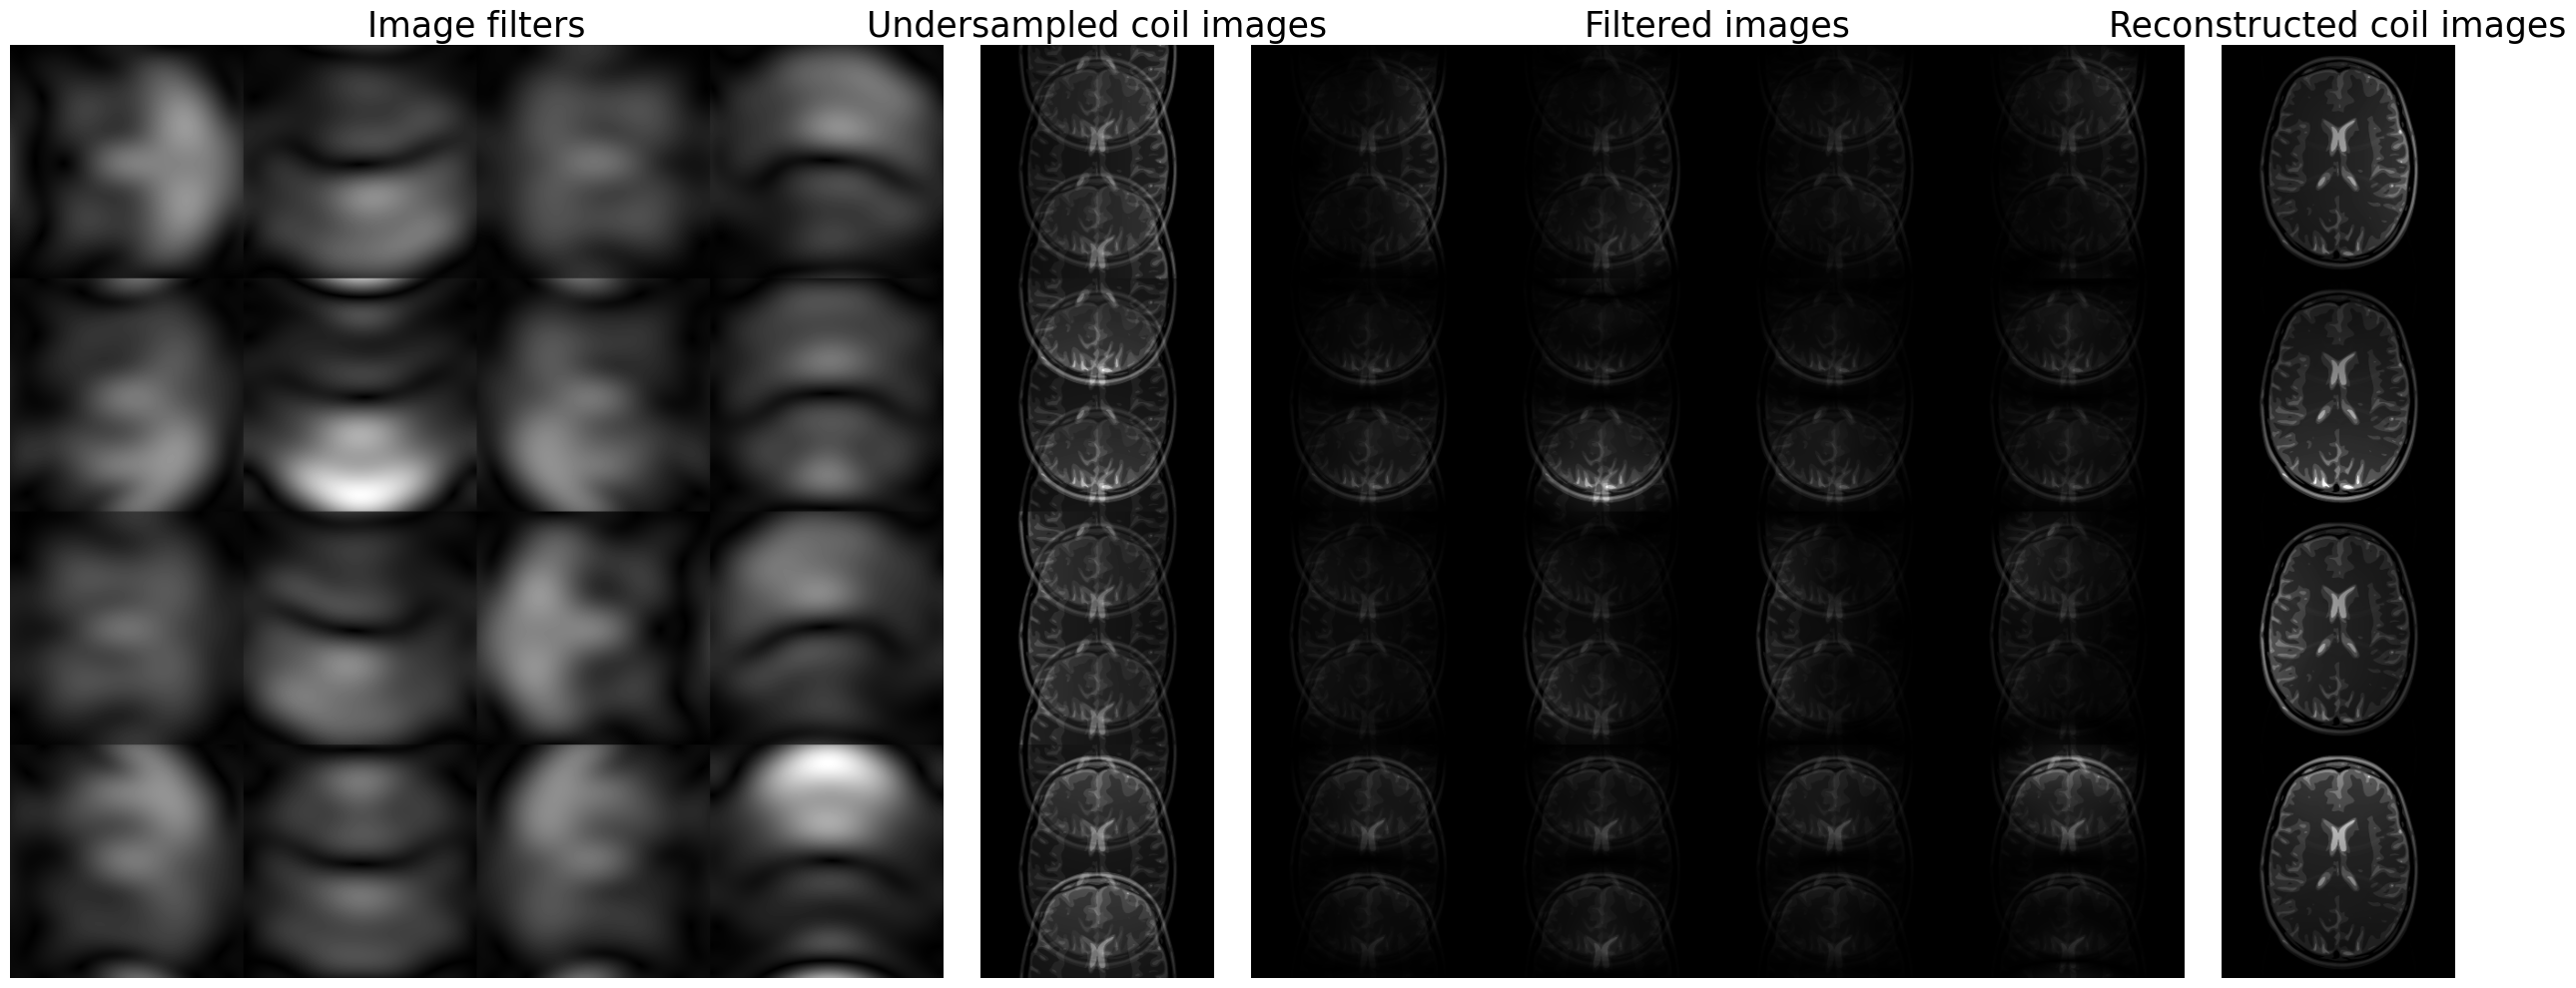

In [20]:
plt.figure(figsize = (50,10))
plt.subplot(141)
plt.title("Image filters", fontsize = 25)
plt.imshow(np.abs(stitch(kernels.reshape(ny,nx,-1),4)), cmap ="gray")
plt.axis('off')

plt.subplot(142)
plt.title("Undersampled coil images", fontsize = 25)
plt.imshow(np.abs(stitch(ifft2c(dataR),4)), cmap ="gray")
plt.axis('off')

plt.subplot(143)
plt.title("Filtered images", fontsize = 25)
plt.imshow(np.abs(stitch(imgkernels.reshape(ny,nx,-1),4)), cmap ="gray")
plt.axis('off')

plt.subplot(144)
plt.title("Reconstructed coil images", fontsize = 25)
plt.imshow(np.abs(stitch((result),4)), cmap ="gray")
plt.axis('off')
plt.subplots_adjust(wspace=-0.9)
plt.tight_layout()

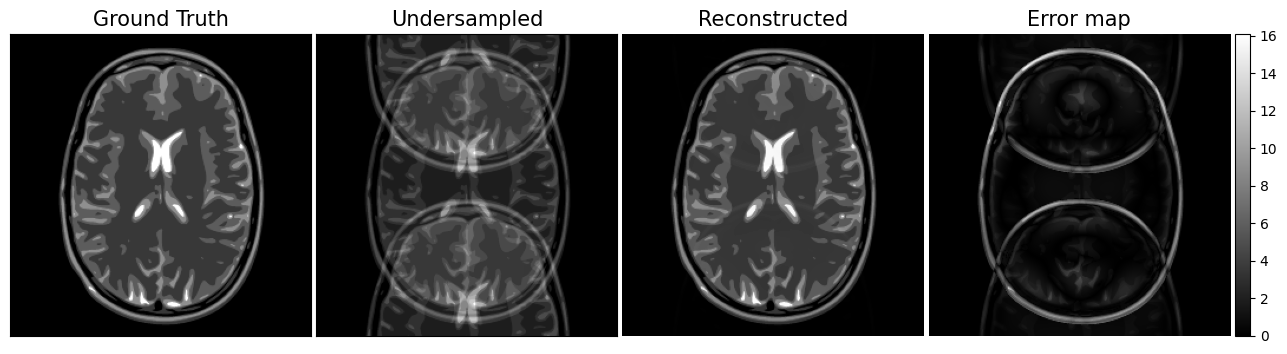

In [21]:
fig = plt.figure(figsize = (16,12))
grid = ImageGrid(fig, 111,
                 nrows_ncols = (1,4),
                 axes_pad = 0.05,
                 cbar_location = "right",
                cbar_size="5%",
                 cbar_mode='single',
                cbar_pad=0.05,
                )
grid[0].imshow(np.abs(rsos(ifft2c(data))),cmap='gray')
grid[0].set_title('Ground Truth', fontsize = 15)
grid[0].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

grid[1].imshow(np.abs(rsos(ifft2c(dataR))),cmap='gray')
grid[1].set_title('Undersampled', fontsize = 15)
grid[1].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

grid[2].imshow(np.abs(rsos(result)),cmap='gray')
grid[2].axis('off')
grid[2].set_title('Reconstructed', fontsize = 15)

im1 = grid[3].imshow(abs(rsos(rawImage) - np.abs(rsos(result))),cmap='gray')
grid[3].axis('off')
grid[3].set_title('Error map', fontsize = 15)
plt.colorbar(im1, cax=grid.cbar_axes[0])
plt.savefig("grappa_output2.png", format = "pdf",bbox_inches='tight')